# Table tennis winning probabilities

This notebook helps you estimate your chances of winning a game of [table tennis](https://en.wikipedia.org/wiki/Table_tennis). It takes into account the probability of scoring for both players, i.e. a metric of the players' strength.

[Rules](https://en.wikipedia.org/wiki/Table_tennis#Scoring) are simple:
* the first player to reach 11 points wins
* if both players score 10 points, the first one to gain a lead of 2 points wins

Until 2001 games were played until the first player reached 21 points, it's also possible to account for that using this notebook. Comments and explanations will always be refering to the new rules, though.

## Outline

In this notebook, we'll generate a 2D matrix for the likelihood of player A winning at any given score. We are going to solve this problem backwards, i.e. starting from the end of the game, because solving it forwards one would need to consider $2^{N}$ possible trajectories of the game. N can equal 20 if the game ends 11:9 or even higher if the score reaches 10:10 and continues. Therefore, following all trajectories would be computationally very extensive and not exact because in theory, a game could go on indefinetely. Even Monte Carlo (MC) would require a lot of sampling, especially for scores such as 0:0.

This notebook will determine only the winning probabilities at a score of 11:11 using MC, all other scores will be calculated recursively.

# Packages

Only random, numpy and pandas are essential. Seaborn, palettable and matplotlib are only needed to visualize the results in the very end. 

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
from palettable.colorbrewer.diverging import RdBu_5
import matplotlib.pyplot as plt
%matplotlib inline

# Define settings / rules of table tennis

Define what player A's probability to score $p_A$ is. His opponents probability will be $p_B = 1 - p_A$.

In [2]:
winning_score = 11
winning_threshold = 2

#probabilities of scoring a point
prob_playerA = 0.55 # what is the probability of player A scoring a point?
prob_playerB = 1 - prob_playerA # player B has the remaining probability to score

# Generate matrix

We'll generate the matrix from the perspective of player A. If the probabily is 1 at any given score, it is certain that player A will win. If the probability is 0, it is certain that player A will lose.

player A's score will be represented by the columns, player B's score by the rows.

In [3]:
# set the size of the matrix
matrix_size = winning_score + 1 # needed to have space for 0:0

#initialize matrix of correct size, set all values to nan
prob_playerA_matrix = np.empty((matrix_size, matrix_size)) 
prob_playerA_matrix[:] = np.nan
# convert the np.array to a pd.DataFrame because it's easier to visualize/has a nice format
prob_playerA_DF = pd.DataFrame(prob_playerA_matrix)
prob_playerA_DF

,0,1,2,3,4,5,6,7,8,9,10,11
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Some winning probabilities are obvious:
* player A will always win if he has 11 points and player B has 9 or less points
* player A will always lose if he has 9 or less points and player B has 11 points

We use this as base case for our recursive solution!

In [4]:
prob_playerA_DF[winning_score].loc[:(winning_score-winning_threshold)] = 1 # player A always wins
prob_playerA_DF.loc[winning_score][:(winning_score-winning_threshold)+1] = 0 # player A always loses
prob_playerA_DF

,0,1,2,3,4,5,6,7,8,9,10,11
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


Our solution is taking shape! In order to compute all other probabilities recursively, we need to determine what the odds are at the score 11:11. This is not trivial for any scoring probabilities that are not 0, 0.5 or 1, therefore we are going to solve it using a Monte Carlo approach.

## Monte Carlo approach to difficult probabilities

We generate a class for a table tennis game that stores the score and the winner

In [5]:
class table_tennis_game:
    """A ping pong game with two players"""
    def __init__(self, names=['A', 'B'], score=(0,0)):
        # set the probability of player A to score a point
        self.prob_playerA = prob_playerA
        # player B will score if player A does not, hence his probability of scoring is
        self.prob_playerB = 1.0 - prob_playerA
        # the players can have names
        self.playerA = names[0]
        self.playerB = names[1]             
        # initialize the score to 0:0
        self.score = {self.playerA: score[0], self.playerB: score[1]}
        # at the start of the game, the winner is None
        self.winner = None # winner of the match

Add a function to the class that can score a point according to the probabilities defined by the user.

In [6]:
def play_by_chance(self):
    """randomly score for a player according to their respective probabilities"""
    # draw a random number from 0 to 1
    random_number = random.random()
    # if the random number is smaller than the probability of player A to score, he will score
    if random_number < self.prob_playerA:
        self.score[self.playerA] += 1
    # otherwise, player B will score
    else:
        self.score[self.playerB] += 1

setattr(table_tennis_game, "play_by_chance", play_by_chance)

Add a function to the class that determines if the game has been decided yet

In [7]:
def check_finish(self):
    """check if the game is decided yet, i.e. does any player exceed the 
    winning score while leading by the required margin?"""

    # determine the difference between the scores of both players...
    score_difference = self.score[self.playerA] - self.score[self.playerB]
    # ...if its absolute value exceeds the margin...
    if abs(score_difference) >= winning_threshold:
        # ...and the score difference is positive...
        if score_difference > 0:
            test_winner = self.playerA
            # ...check if player A is winning
            if self.score[test_winner] >= winning_score:
                self.winner = test_winner
        # ...if the score difference is negative...
        elif score_difference < 0:
            # ...check if player B is winning
            test_winner = self.playerB
            if self.score[test_winner] >= winning_score:
                self.winner = test_winner
                    
setattr(table_tennis_game, "check_finish", check_finish)

Determine the chances of winning a game for player A at a given score. Here, the only other parameter input is required (asside from the scoring probability): how many instances should be played during the MC approach? Increasing the number will drive up the accuracy of the prediction but also the computational effort.

In [8]:
def MC_determine_winning_game_probability(input_score=(winning_score,winning_score), no_iterations=10**5):
    """this will return the probability of player A winning the game"""
    
    # store the winner of each instance in a list
    winner_list = []
    # 'play' many games
    for x in range(no_iterations):
        # initialize the game
        game_instance = table_tennis_game(names=('A','B'), score=input_score)
        # play as long as there is no winner
        while game_instance.winner == None:
            game_instance.play_by_chance() # score one point according to the scoring probabilities
            game_instance.check_finish() # check if any player has won yet
        winner_list.append(game_instance.winner) # store the winner

    winning_probability = winner_list.count('A') / float(no_iterations) # divide the number of wins by the number of iterations
    
    return winning_probability

## Calculate probability for 11:11

In [9]:
prob_playerA_DF[winning_score][winning_score] = MC_determine_winning_game_probability(input_score=(winning_score,winning_score))
prob_playerA_DF

,0,1,2,3,4,5,6,7,8,9,10,11
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000


Now we can solve the rest of the probabilities. If the current score is X:Y, there are two possible events:

1. A scores, the new score will be X+1:Y
2. B scores, the new score will be X:Y+1

we know the likelihood of events 1 ($p_{A}$) and 2 ($p_{B}$). Hence, the winning probability at score X:Y $p_{X:Y}$ is

$p_{X:Y} = p_{X+1:Y} * p_{A} + p_{X:Y+1} * p_{B}$

Again, we rely on the fact that we know that 

* 12:10 has a probability of 1 to win
* 10:12 has a probability of 0 to win

In [10]:
def recursively_calculated_probability_to_win(A,B):
    """returns the probability to win the game at a given score
    only two events can happen: player A scores or player B scores, both events have a known probability"""
    
    # raise an error if one tries to calculate anything outside of the matrix or 11:11
    if (A == winning_score and B == winning_score) or (A > winning_score or B > winning_score):
        raise ValueError('The probability for this score cannot be determined recursively.')
    
    # account for the special cases 11:10 and 10:11
    # they will cause an error because 12 is out of bound of the matrix
    try:
        likelihood_to_win_if_A_scores = prob_playerA_DF[A+1][B]
    # therefore we'll catch them with this exception...
    except:
        # ...and set the likelihood to win at a score of 12:10 to 1
        if A == winning_score:
            likelihood_to_win_if_A_scores = 1
    
    try:
        likelihood_to_win_if_B_scores = prob_playerA_DF[A][B+1]
    # catch the exception of 10:12
    except:
        if B == winning_score:
            likelihood_to_win_if_B_scores = 0        
    
    # "moving right" in the matrix
    A_scores = likelihood_to_win_if_A_scores * prob_playerA 
    # "moving down" in the matrix
    B_scores = likelihood_to_win_if_B_scores * prob_playerB
    
    return A_scores + B_scores

First, we need to determine the two missing values on the "edge" of our matrix.

In [11]:
prob_playerA_DF[winning_score][winning_score-1] = recursively_calculated_probability_to_win(winning_score,winning_score-1)
prob_playerA_DF[winning_score-1][winning_score] = recursively_calculated_probability_to_win(winning_score-1,winning_score)
prob_playerA_DF

,0,1,2,3,4,5,6,7,8,9,10,11
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


Afterwards, we can iterate backwards over the remaining part of the matrix.

In [12]:
for A in reversed(range(winning_score)):
    for B in reversed(range(winning_score)):
        prob_playerA_DF[A][B] = recursively_calculated_probability_to_win(A,B)
prob_playerA_DF

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.686942,0.757927,0.822114,0.877065,0.921170,0.953940,0.976088,0.989377,0.996199,0.999022,0.999864,1.000000
1,0.600181,0.679476,0.754953,0.823157,0.881119,0.926869,0.959846,0.981038,0.992749,0.997994,0.999697,1.000000
2,0.503265,0.587227,0.671592,0.752315,0.825203,0.886564,0.933945,0.966725,0.986338,0.995912,0.999327,1.000000
3,0.400645,0.484116,0.572930,0.663230,0.750205,0.828655,0.893881,0.942753,0.974635,0.991739,0.998505,1.000000
4,0.298626,0.375565,0.462562,0.556928,0.654322,0.748933,0.834149,0.903786,0.953731,0.983470,0.996677,1.000000
5,0.204590,0.269235,0.347226,0.437890,0.538686,0.644781,0.749036,0.842743,0.917384,0.967327,0.992615,1.000000
6,0.125579,0.173913,0.236415,0.314695,0.409014,0.517359,0.634506,0.751515,0.856342,0.936420,0.983590,1.000000
7,0.066504,0.097521,0.140740,0.199416,0.276593,0.374179,0.491495,0.623393,0.758468,0.878767,0.963533,1.000000
8,0.028595,0.044697,0.069025,0.105089,0.157322,0.230792,0.330287,0.458301,0.611436,0.775164,0.918963,1.000000
9,0.008914,0.014964,0.024947,0.041248,0.067525,0.109188,0.173824,0.271136,0.411325,0.599409,0.819918,1.000000


We can also visualize it:

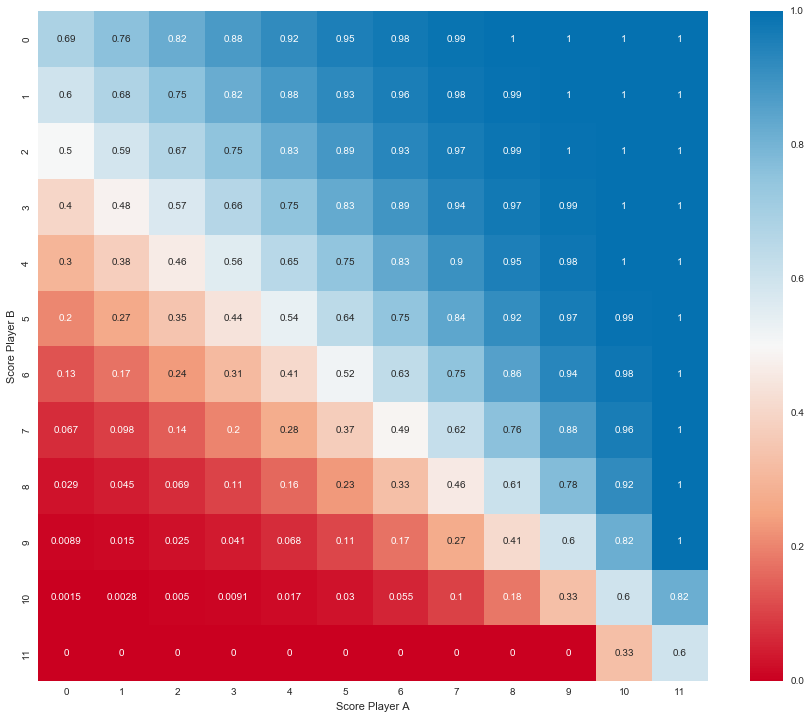

In [13]:
plt.figure(figsize=(15,12))
sns.heatmap(prob_playerA_DF, annot=True, cmap=RdBu_5.mpl_colormap)
plt.xlabel('Score Player A')
plt.ylabel('Score Player B')

# Conclusions

We recursively calculated the probabilities of winning a table tennis game for all scores. The only required input is the probability of the players scoring a single point. We rely on the fact that we know certainly who will win for selected scores, i.e. we have a base case. Using a Monte Carlo approach we can solve the probabilities in the required case (11:11) in which we don't.

Playing around with the scoring probabilities we learn that being slightly better than your opponent will help you win regularly. This is amplified if you play by the old rules. 

Example:
If you score with a chance of 55%, you will win ~69% of games  playing until 11 and 75% of games until 21. If you play until 11, better give your opponent a 0:2 lead for a thrilling game.